<a href="https://colab.research.google.com/github/paulsubarna/FedWeIT/blob/main/Pytorch_1_1_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 1.1. Introductory Tutorial: Solution

In this introductory tutorial, we will revisit some of the fundamental concepts involved in training neural networks with PyTorch.

To begin, we will re-familiarize ourselves with the process of loading data and working with PyTorch’s built-in utilities.

The tutorial will cover the following topics:
1. Basic usage of PyTorch DataLoaders
2. Loading and preprocessing built-in datasets (e.g., CIFAR-10, Imagenette)
3. Creating a custom dataset class
4. Applying data transformations
5. Handling image and text data



**TO-DO**
1. Create a simple tensor dataset of arbitrary shape and load it using PyTorch’s built-in utilities such as torch.utils.data.TensorDataset and DataLoader
2. The DataLoader class provides several parameters that can affect performance. Can you think of ways to configure the same DataLoader to load data more efficiently (i.e., faster)?


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import time
# Simple tensor data
X = torch.randn(10000, 3)
y = torch.randint(0, 2, (10000,))

# Dataset and DataLoader
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=10, shuffle=True)
start= time.time()
for batch_X, batch_y in loader:
    print('The input data shape: ',batch_X.shape, batch_y.shape)
    out = nn.Linear(3,2)(batch_X)
    print('The output shape: ',out.shape)
    break

#** TO **
### Can you think of a way how to use the same DataLoader method to load the data faster?
# To load and preprocess data, we need to assign how many subprocesses we want to parallelize our data loading step in our DataLoader object .
fast_loader = DataLoader(dataset, batch_size = 10, shuffle= True, num_workers = 2)

The input data shape:  torch.Size([10, 3]) torch.Size([10])
The output shape:  torch.Size([10, 2])


**Working with Images**

We will explore different data modalities and learn how to load various types of data in PyTorch.
1. The torchvision library provides several benchmark image datasets such as CIFAR-100, Imagenette, and others.
2. Try loading one of these pre-built datasets and visualize a few sample images using Matplotlib.

torch.Size([64, 3, 32, 32]) torch.Size([64])


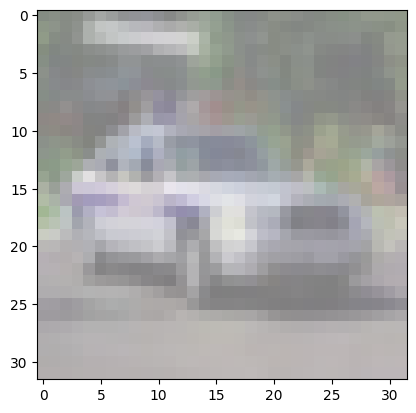

In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=False, num_workers=2)
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

## Visualizing data samples
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(images[0])



Custom Dataset class
=============
However, in some cases, when the dataset is obtained from external sources, the built-in Dataset or DataLoader classes may not work as expected due to differences in the dataset’s structure or format. To address this, we can define a custom Dataset subclass that inherits from PyTorch’s Dataset class and adapts the loading process to our specific data layout

`torch.utils.data.Dataset` is an abstract class representing a dataset.
Your custom dataset should inherit `Dataset` and override the following
methods:

-   `__len__` so that `len(dataset)` returns the size of the dataset.
-   `__getitem__` to support the indexing such that `dataset[i]` can be used to get ``i^th`` sample.

Load the Imagenette dataset from PyTorch. You will notice that the directory is organized into multiple subfolders, each representing a class containing its corresponding image samples.

In your custom dataset class, read the dataset structure inside the ``__init__`` method, but defer loading individual samples to the ``__getitem__`` method. This approach is memory-efficient since the data are not all loaded into memory at once, but accessed only when needed.

Each sample in the dataset will be a tuple of (image, label).
Additionally, our dataset class will include an optional transform argument, allowing you to apply preprocessing or data augmentation to each sample. We will discuss the importance and use of transform in the next cells.

In [18]:
#/content/data/imagenette2/train
import os
from PIL import Image
from torch.utils.data import Dataset
train_data = datasets.Imagenette(root='data', split="train", download=True, transform=False)


class ImageNet_Dataset(Dataset):
  def __init__(self, image_directory, transform) -> None:
      super().__init__()
      self.transform = transform
      self.image_directory =  image_directory
      # Get the class labels from the directory names
      class_labels = os.listdir(image_directory)
      self.images = []
      self.labels = [] # Separate list for storing labels
      self.labels_to_idx = {}

      for idx, label in enumerate(class_labels):
        self.labels_to_idx[label] = idx

        label_path = os.path.join(image_directory, label)
        #print(label_path)
        # Check if the label_path is a directory before listing its contents
        if os.path.isdir(label_path):
            for image_ in os.listdir(label_path):
              image_path = os.path.join(label_path, image_)
              if image_path.endswith(".JPEG"):
                self.images.append(image_path)
                self.labels.append(idx) # Append integer label to the new list


  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      image_path = self.images[idx]
      label = self.labels[idx]
      image = Image.open(image_path).convert('RGB') # Open image and convert to RGB
      if self.transform:
          image = self.transform(image)

      return image, label

100%|██████████| 1.56G/1.56G [00:33<00:00, 47.0MB/s]


In [26]:
imagenette = ImageNet_Dataset("/content/data/imagenette2/train", transform=transforms.ToTensor())
dataloader = DataLoader(imagenette, batch_size=32, shuffle=True)
try:
  images , labels = next(iter(dataloader))
except:
  print('size mismatch across input images: Use proper transformations on the input data')

size mismatch across input images: Use proper transformations on the input data


Transforms
==========

One issue we can see from the above is that the samples are not of the
same size. Since most neural networks expect inputs of a fixed dimension, we need to perform some preprocessing to standardize the image sizes.
three transforms object with the built in PyTorch function `` transforms.Compose ``:

Hint: Use augmentation techniques like Rescale, RandomCrop, RandomHorizontalFlip, ToTensor, etc.

`` State``: Why are transformations such as RandomHorizontalFlip, ColorJitter for data helpful in data processing?




In [28]:
transform = transforms.Compose((
    transforms.RandomResizedCrop(256),
    transforms.Resize((224, 224)),
    transforms.ToTensor()))


imagenette = ImageNet_Dataset("/content/data/imagenette2/train", transform=transform)
dataloader = DataLoader(imagenette, batch_size=32, shuffle=True, num_workers = 2)
images , labels = next(iter(dataloader))
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


## Working with texts

Unlike image data, textual data requires a few additional preprocessing steps before it can be used for model training. You can build a custom vocabulary from your input corpus and design a tokenizer around it. However, there are also publicly available pretrained tokenizers (such as those in Hugging Face) that eliminate the need to create one from scratch.

Following a similar approach to what we used for image data, let’s now create a custom Dataset class for textual data to handle loading and preprocessing.

In [30]:
#Create a sample piece of text as textual data for the model


In [32]:
# Create a sample text file
sample_text = """This is the first sentence.\tpositive
This is the second sentence, which is a bit longer.\tnegative
A third sentence for testing.\tpositive
Another negative example here.\tnegative
Short positive example.\tpositive
"""

with open("./train.txt", "w") as f:
    f.write(sample_text)

# Create a sample validation file
sample_val_text = """This is a validation sentence.\tpositive
Another one for validation.\tnegative
"""

with open("./val.txt", "w") as f:
    f.write(sample_val_text)

print("Sample text files created: ./train.txt and ./val.txt")

Sample text files created: ./train.txt and ./val.txt


In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
label2idx = {"negative": 0, "positive": 1}
class TextDataset(Dataset):
    def __init__(self, file_path, tokenizer, label2idx, max_length=128):
        self.samples = []
        self.tokenizer = tokenizer
        self.label2idx = label2idx
        self.max_length = max_length

        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                text, label = line.strip().split("\t")
                self.samples.append((text, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, label = self.samples[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',       # pad to fixed length
            truncation=True,            # truncate long text
            max_length=self.max_length, # fixed input size
            return_tensors='pt'         # return PyTorch tensors
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}  # remove batch dim
        item['labels'] = torch.tensor(self.label2idx[label], dtype=torch.long)
        return item


train_dataset = TextDataset("./train.txt", tokenizer, label2idx)
val_dataset = TextDataset("./val.txt", tokenizer, label2idx)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

batch = next(iter(train_loader))
for key, val in batch.items():
    print(f"{key}: {val.shape}")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

input_ids: torch.Size([5, 128])
token_type_ids: torch.Size([5, 128])
attention_mask: torch.Size([5, 128])
labels: torch.Size([5])


## Weight Initialization

Now that we have explored how to load different types of data, another crucial aspect of model training is weight initialization. There are several reasons why randomly initializing the weights of a neural network may not be ideal.

**TO-DO**
1. Can you state some of the reasons?
2. Define a simple 2-3 layer MLP network which we will need for the following cells

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


## Different types of Weight Initialization

There exists several types of weight initialization techniques. Few of the popular ones are:
1. Xavier Initialization
2. Uniform Initialization
3. Kaiming Initialization
4. Orthogonal initilization

**To-DO**

1. Define functions for each weight initialization technique.


In [3]:
def init_xavier(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        init.zeros_(m.bias)

model = SimpleNet()
model.apply(init_xavier)

def init_uniform(m):
    if isinstance(m, nn.Linear):
        init.uniform_(m.weight, a=0, b=1)
        init.zeros_(m.bias)

model = SimpleNet()
model.apply(init_uniform)

def init_kaiming(m):
    if isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, nonlinearity='relu')
        init.zeros_(m.bias)

model = SimpleNet()
model.apply(init_kaiming)

def init_orthogonal(m):
    if isinstance(m, nn.Linear):
        init.orthogonal_(m.weight)
        init.zeros_(m.bias)

model = SimpleNet()
model.apply(init_orthogonal)


SimpleNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

** TO-DO **

1. Next, visualize the weight distribution of individual layers in your neural network, preferably the first layer, for each initialization technique.
2. Do you notice any differences between the distributions? In addition, under what circumstances would you choose a specific type of initialization?

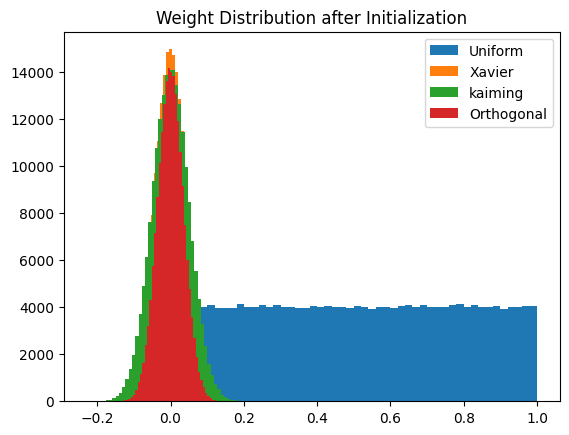

In [38]:
import matplotlib.pyplot as plt
model = SimpleNet()
model.apply(init_uniform)
weights = model.fc1.weight.data.view(-1).cpu().numpy()
plt.hist(weights, bins=50)

model = SimpleNet()
model.apply(init_xavier)
weights_ = model.fc1.weight.data.view(-1).cpu().numpy()
plt.hist(weights_, bins=50)

model = SimpleNet()
model.apply(init_kaiming)
weights_ = model.fc1.weight.data.view(-1).cpu().numpy()
plt.hist(weights_, bins=50)

model = SimpleNet()
model.apply(init_orthogonal)
weights_ = model.fc1.weight.data.view(-1).cpu().numpy()
plt.hist(weights_, bins=50)
plt.legend(["Uniform", "Xavier", 'kaiming', "Orthogonal"])
plt.title("Weight Distribution after Initialization")
plt.show()


** TO-DO **

1. Compare the difference in output variance between the different types of weight initialization. Hint: use output.var()

In [39]:
def compare_inits(init_fn, name):
    model = SimpleNet()
    model.apply(init_fn)
    x = torch.randn(100, 784)
    with torch.no_grad():
        y = model(x)
    print(f"{name} output variance: {y.var().item():.4f}")

compare_inits(init_uniform, "Uniform")
compare_inits(init_xavier, "Xavier")
compare_inits(init_kaiming, "Kaiming")
compare_inits(init_orthogonal, "Orthogonal")


Uniform output variance: 3666744064.0000
Xavier output variance: 0.8332
Kaiming output variance: 2.2624
Orthogonal output variance: 0.2851


** TO-DO **

The final step would be to bring all these components together to train a neural Network.

1. Select a simple dataset from PyTorch dataset library and train a network network using different initializations. Report the empirical findings.
  - Which initialization method facilitates faster convergence?
  - Which method achieves the best overall performance?

In [20]:
### TO-DO
mnist = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist, batch_size=64, shuffle=False)
from tqdm import tqdm

# Define your training and validation split

## Train function
model = SimpleNet()
def train(model, epochs, train_loader, optimizer, criterion):
    model.train()
    losses = []
    accuracy = []
    for _ in tqdm(range(epochs)):
      total_loss = 0.0
      for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.view(data.size(0), -1)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == target).float().mean()
        total_loss += loss

      avg_loss = total_loss / len(train_loader)
      avg_acc = acc / len(train_loader)
      losses.append(avg_loss)
      accuracy.append(avg_acc)
    return accuracy, losses

def test(model, test_loader):
    model.eval()

    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0), -1)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

## Train the models with different initializations
model = SimpleNet()
weight_init = [init_uniform, init_kaiming, init_xavier, init_orthogonal]
train_acc_per_init = []
train_loss_per_init = []
test_acc_per_init = []
for wt_init in weight_init:
  model = SimpleNet()
  model.apply(wt_init)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  criterion = nn.CrossEntropyLoss()
  acc, loss = train(model, 10, train_loader, optimizer, criterion)
  train_acc_per_init.append(acc)
  train_loss_per_init.append(loss)
  acc_ = test(model, test_loader)
  test_acc_per_init.append(acc_)

# You are free to choose any optimizer such as SGD or ADAM


100%|██████████| 10/10 [01:58<00:00, 11.86s/it]


In [21]:
for i in range(len(train_acc_per_init)):
  train_acc_per_init[i] = [float(l.detach().cpu()) for l in train_acc_per_init[i]]
  train_loss_per_init[i] = [float(l.detach().cpu()) for l in train_loss_per_init[i]]
  test_acc_per_init[i] = float(test_acc_per_init[i])

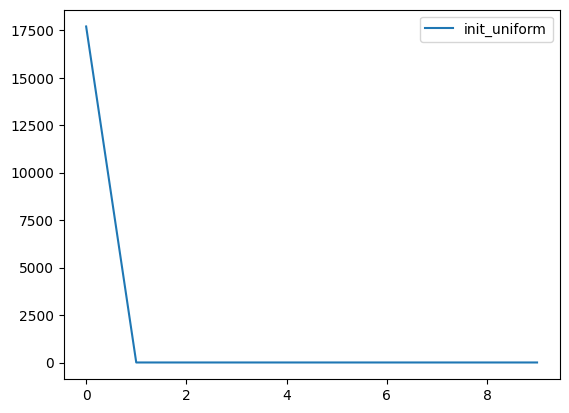

In [34]:
import matplotlib.pyplot as plt
## plot uniform initialization
plt.plot(train_loss_per_init[0], label=f"{weight_init[0].__name__}")
plt.legend()
#plt.plot(loss)

The accuracy with init_kaiming is 99.67833333333333
The accuracy with init_xavier is 99.56666666666666
The accuracy with init_orthogonal is 99.59166666666667


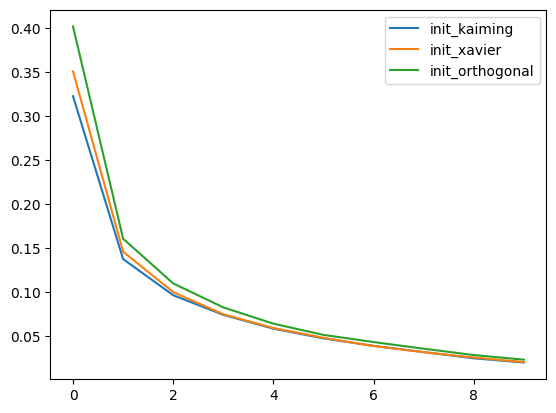

In [36]:
## Plot kaiming, orthogonal, or xavier
for i in range(1, len(train_loss_per_init)):
  print(f'The accuracy with {weight_init[i].__name__} is {test_acc_per_init[i]}')
  plt.plot(train_loss_per_init[i], label=f"{weight_init[i].__name__}")
plt.legend()
#plt.plot(train_loss_per_init[3])